In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Spectral'

In [2]:
def sigmoid(z) :
    """
    Returns the sigmoid function of the given input
    """
    return 1 /(1 + np.exp(-z))

def sigmoid_prime(z) :
    """
    Returns the derivative of the sigmoid function of the given input
    """
    return sigmoid(z)*(1-sigmoid(z))

def fp(x, eps):
    """
    Returns the value the SReLU takes in the interval -eps to eps
    
    The polynomial satifies the following conditions:
    fp(eps) = eps
    fp'(eps) = 1
    fp(-eps) = 0
    fp'(-eps) = 0
    
    """
    a_0 = eps/4
    a_1 = 0.5
    a_2 = 1/(4*eps)
    a_3 = 0
    
    return  a_0 + a_1*x + a_2*x**2 + a_3*x**3 

def SReLU(x, eps):
    """
    Returns a smoothed ReLU function with parameter epsilon
    """
    return fp(x, eps)*(np.abs(x) < eps) + x*(x >= eps)


def fp_prime(x, eps):
    """
    Returns derivative of the fp(x) with respect to x
    """
    a_0 = eps/4
    a_1 = 0.5
    a_2 = 1/(4*eps)
    a_3 = 0
    
    return  a_1 + 2*a_2*x + 3*a_3*x**2 

def SReLU_prime(x,eps):
    """
    Returns the derivative of the smoothed ReLU function
    """
    return fp_prime(x, eps)*(np.abs(x) < eps) + 1*(x >= eps)

def relu(z): 
    """
    Returns the rectified linear unit applied to the given input 
    """
    return np.maximum(0,z)

def relu_prime(z) :
    """
    Returns the derivative of rectified linear unit applied to the given input 
    """
    return 1*(z>=0)

def SReLU_prime_wrt_eps(x,eps):
    """
    Returns the derivative of the SReLU function
    with respect to epsilon given the input and parameter eps
    """
    return (1/4-(x**2)/(4*eps**2))*(np.abs(x) < eps)

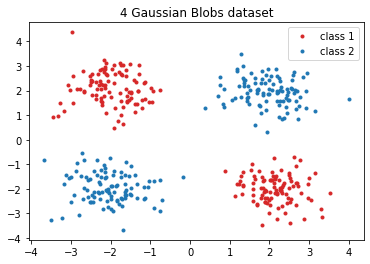

In [3]:
from sklearn.datasets import make_blobs

N = 400 # no. points per class

X, y = make_blobs(n_samples = N, centers = [(2,-2),(-2,-2),(-2,2),(2,2)], 
                  n_features = 2, cluster_std = 0.6, random_state = 1)
labels_orig = y
y = np.mod(labels_orig, 2)
y = y.reshape(y.shape[0],1)

plt.title('4 Gaussian Blobs dataset')
plt.plot(X[y[:,0]==0,0], X[y[:,0]==0,1], color='tab:red', marker='.', linestyle='None',label='class 1')
plt.plot(X[y[:,0]==1,0], X[y[:,0]==1,1], color='tab:blue', marker='.', linestyle='None', label='class 2')
plt.legend()
plt.show()


In [4]:
def plotboundary_accuracy(X, y, W1, b1, W2, b2,eps):
    """
    Returns the accuracy for the given parameters and plots the decision boundary of the data
    """
    predicted_class = np.dot(SReLU(np.dot(X, W1) + b1,eps), W2) + b2
    print('Accuracy: %.0f %%' % (100*np.mean((predicted_class >0.5) == y)))

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),np.arange(y_min, y_max, 0.02))
    Z_axis = np.dot(SReLU(np.dot(np.c_[xx.ravel(), yy.ravel()], W1) + b1,eps), W2) + b2
    Z_axis = (Z_axis > 0.5)
    Z_axis = Z_axis.reshape(xx.shape)
    plt.contourf(xx, yy, Z_axis, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y[:,0], s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [5]:
def initialize_parameters(n_x,n_y,n_h):
    """
     Initialization of the weights and biases for the neural network
     n_x: number of inputs nodes
     n_y: number of output nodes
     n_h: number of hidden nodes
    """
    #np.random.seed(1)                   # Random seed for weights
    W1 = 1.0 * np.random.randn(n_x,n_h)/np.sqrt(n_x)  # [n_x, n_h ]
    b1 = np.zeros((1,n_h))              # [1, n_h ]
    W2 = 1.0 * np.random.randn(n_h,n_y)/np.sqrt(n_h) # [n_h, n_y ]
    b2 = np.zeros((1,n_y))              # [1, n_y ]
    #np.random.seed(None)              # Random seed for weighs
    
    return W1, b1, W2, b2   # Return initalise weights and biases

In [6]:
def forward_prop(X, W1, b1, W2, b2,eps):
    """
     Return the parameters after one foward pass 
     N: Number of points per class
     X: dimension [2N, n_x]
     n_x: number of inputs nodes
     n_y: number of output nodes
     n_h: number of hidden nodes
     
    """
    Z1 = np.dot(X, W1) + b1   # [2N, n_h]
    A1 = SReLU(Z1,eps) # [2N, n_h]
    Z2 = np.dot(A1, W2) + b2  # [2N, n_y]
    A2 = sigmoid(Z2)          # [2N, n_y]
    
    return Z1, A1, Z2, A2

In [7]:
def cost(Y, A2):
    """
    Returns the L2 error between the predicted values 
    by the network A2 and the actual values of the data Y
    """
    m = Y.shape[0]
    return np.sum(np.square(A2-Y))/m


In [8]:
def back_prop(X,y, Z1, A1, Z2, A2, reg, eps):
    """
     Return the gradient of parameters with respect to the loss after one foward pass 
     reg: regularisation parameter
     eps: smoothed ReLU parameter epsilon
     N: Number of points per class
     X: dimension [2N, n_x]
     n_x: number of inputs nodes
     n_y: number of output nodes
     n_h: number of hidden nodes
     """
    
    m = X.shape[0]                # Number of data points in total, 2N
    
    dZ2 = 2*(A2 - y)/m              # Derivative of cross-entropy loss is (A2-y), [m,1]
    dZ2 = dZ2*sigmoid_prime(Z2)   # Derivative with respect to Z2, [m,1]

    dW2 = np.dot(A1.T, dZ2)                     # Derivative with respect to W2, [n_h, n_y ]
    db2 = np.sum(dZ2, axis=0, keepdims=True)    # Derivative with respect to b2, [1, n_y ]

    dA1 = np.dot(dZ2, W2.T)                             # Derivative with respect to A1, [m, n_h]
    dZ1 = np.multiply(dA1, SReLU_prime(Z1,eps))  # Derivative with respect to Z1, [m, n_h]
    
    # Derivative with respect to epsilon, [1, n_h]
    depsilon = np.sum(np.multiply(dA1,  SReLU_prime_wrt_eps(Z1, eps)), axis = 0, keepdims=True)
    
    dW1 = np.dot(X.T, dZ1)                   # Derivative with respect to W1, [n_x, n_h]
    db1 = np.sum(dZ1, axis=0, keepdims=True) # Derivative with respect to b1, [1, n_h]

    dW2 = dW2 + reg * W2 # regularisation of weight W2
    dW1 = dW1 + reg * W1 # regularisation of weight W1

    return dW1, db1, dW2, db2, depsilon

In [9]:
def update_parameters(W1, b1, W2, b2, epsilon_vector, dW1, db1, dW2, db2, depsilon_vector, learning_rate):
    """
    Returns the updated values of the parameters 
    after the given interation 
    """
    
    W1 = W1 - dW1 * learning_rate
    b1 = b1 - db1 * learning_rate
    W2 = W2 - dW2 * learning_rate
    b2 = b2 - db2 * learning_rate
    epsilon_vector = epsilon_vector - depsilon_vector * 0.1
    
    return W1, b1, W2, b2, epsilon_vector

In [10]:
C = X.shape[0]
np.random.seed(5)
# You need to shuffle the data in order to get blue and red points in all the sets
perm = np.random.permutation(len(X)) # This allows us to shuffle data without losing the labels on the y-vector
X_shuffle= X[perm]
y_shuffle = y[perm]
np.random.seed(None)

# We define a size for train set
train_index = int(0.7*C)

In [11]:
# Create sets, same method as for SGD
X_train, y_train = X_shuffle[:train_index,:], y_shuffle[:train_index] 
X_test, y_test = X_shuffle[train_index:,:], y_shuffle[train_index:]

In [12]:
# Setting parameters
epochs = 1000
learning_rate = 0.2
runs = 10
reg = 1e-3
sample_size = 0.1
batch_size = int(sample_size*C*0.7)
n_h = 3
n_x = 2
n_y = 1

In [13]:
accuracy_test = np.zeros(runs)
losses_test =  np.zeros(runs)
epsilons =  np.zeros((runs,n_h))
plot_epsilon= np.zeros([runs, epochs+1, n_h])
losses_train = np.zeros((runs,epochs))
    
for n in range(runs):
    
    W1, b1, W2, b2 = initialize_parameters(2,1,n_h)
    epsilon_vector = np.random.uniform(0.2,0.8,(1,n_h))
    plot_epsilon[n,0,:]= epsilon_vector
        
    for i in range(epochs):
    
        index = np.random.randint(0, train_index , batch_size)
        X_i = X_train[index,:]
        y_i = y_train[index]

        Z1, A1, Z2, A2 = forward_prop(X_i, W1, b1, W2, b2, epsilon_vector)
            
        dW1, db1, dW2, db2, depsilon= back_prop(X_i, y_i, Z1, A1, Z2, A2, reg, epsilon_vector)
        
        W1, b1, W2, b2, epsilon_vector = update_parameters(W1, b1, W2, b2, epsilon_vector, 
                                                      dW1, db1, dW2, db2, depsilon, learning_rate) 
        plot_epsilon[n,i+1, :] = epsilon_vector
        pc_train =sigmoid(np.dot(SReLU(np.dot(X_i, W1) + b1,epsilon_vector), W2) + b2)
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)
        losses_train[n, i] =  cost(y_i, pc_train) + reg_loss
            
    pc_test =sigmoid(np.dot(SReLU(np.dot(X_test, W1) + b1, epsilon_vector), W2) + b2)
    accuracy_test[n] = (100*np.mean((pc_test >0.5) == y_test))
    
    reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)
    losses_test[n] =  cost(y_test, pc_test) + reg_loss  # We only care about the last loss of the training 
    epsilons[n,:] = epsilon_vector

In [17]:
print('Stochastic Gradient Descent 4-blobs')
print('Epochs: %.0f' % epochs)
print('Number of neurons: %.0f' % n_h)
print('Learning rate: %.2f' % learning_rate)
print('Mean Accuracy: %.2f %%' % np.mean(accuracy_test))
print('Std: %.2f %%' % np.std(accuracy_test))
print('Mean Loss: %.2f' % np.mean(losses_test))
print('Std: %.2f' % np.std(losses_test))
print('Mean Epsilon Values: ' + ' '.join(map(str, np.around(np.mean(epsilons,axis = 0),3))))
print('Std: ' + ' '.join(map(str, np.around(np.std(epsilons,axis = 0),3))))

Stochastic Gradient Descent 4-blobs
Epochs: 1000
Number of neurons: 3
Learning rate: 0.20
Mean Accuracy: 97.08 %
Std: 8.48 %
Mean Loss: 0.03
Std: 0.04
Mean Epsilon Values: 0.471 0.484 0.314
Std: 0.163 0.173 0.101


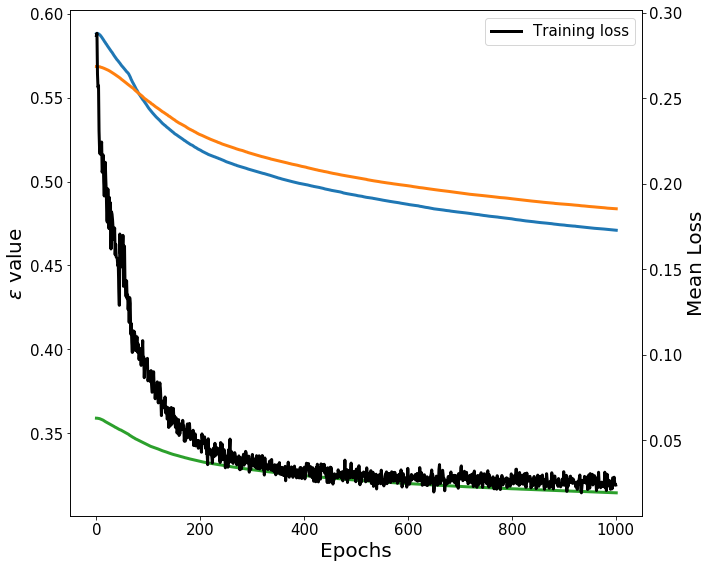

In [18]:
x = np.linspace(0,epochs+1,epochs+1)
epsilons_mean = np.mean(plot_epsilon, axis=0)
losses_mean = np.mean(losses_train, axis = 0)

fig, ax1 = plt.subplots(figsize=(10,8))
ax1.set_xlabel('Epochs', fontsize = 20)
ax1.set_ylabel(r'$\varepsilon$ value', fontsize = 20)
ax1.plot(x, epsilons_mean, label=r'$\varepsilon$', linewidth=3)
ax1.tick_params(axis='y')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15) 

x = np.linspace(0,epochs,epochs)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Mean Loss', color='black', fontsize = 20) # we already handled the x-label with ax1
ax2.plot(x,losses_mean, color='black', label='Training loss', linewidth=3)
ax2.tick_params(axis='y', labelcolor='black')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h2, l2, loc=0, fontsize=15)
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 

fig.tight_layout()
plt.show()